Dataset loaded — 1715 samples, 201 features.


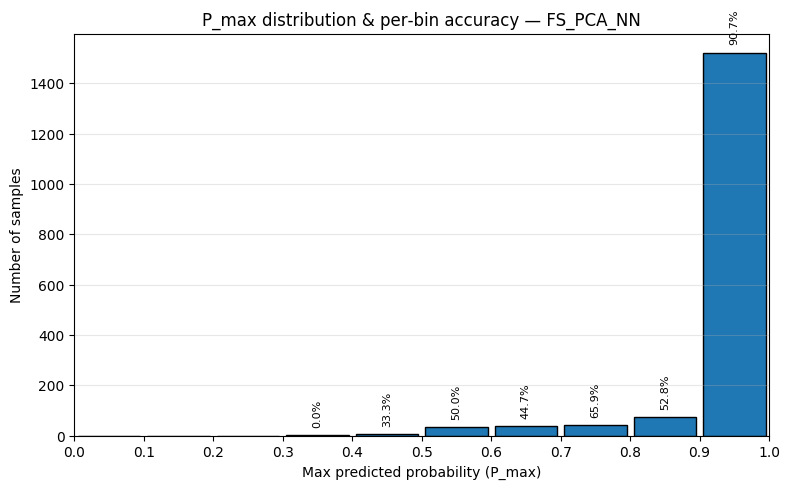

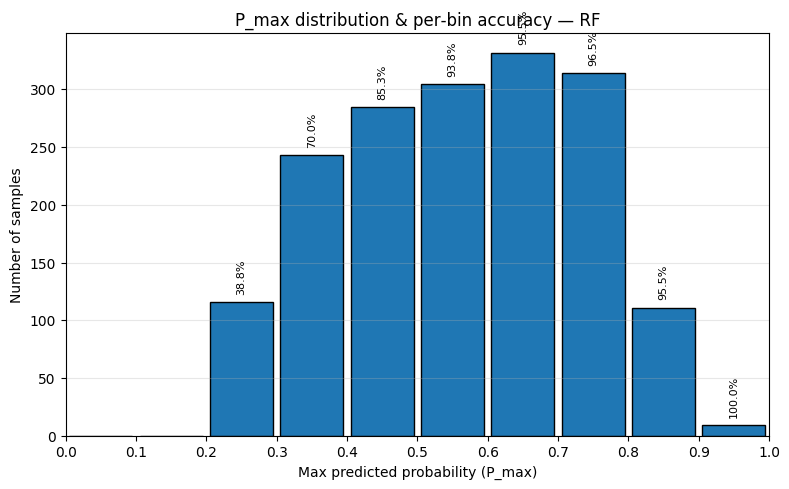

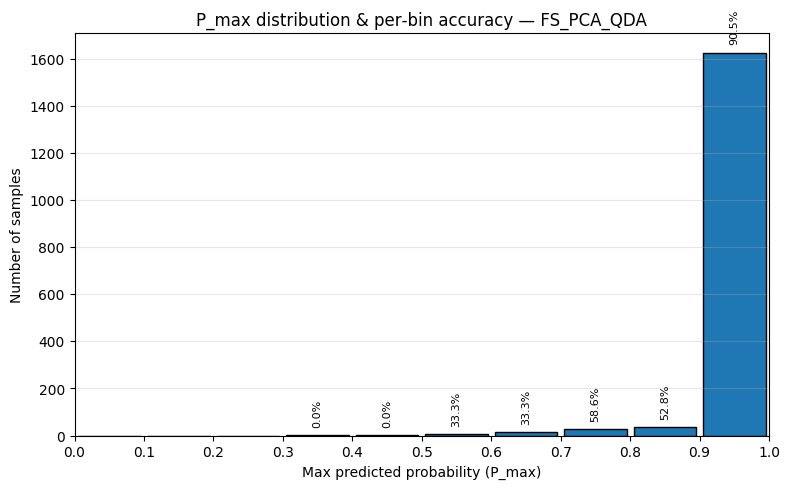

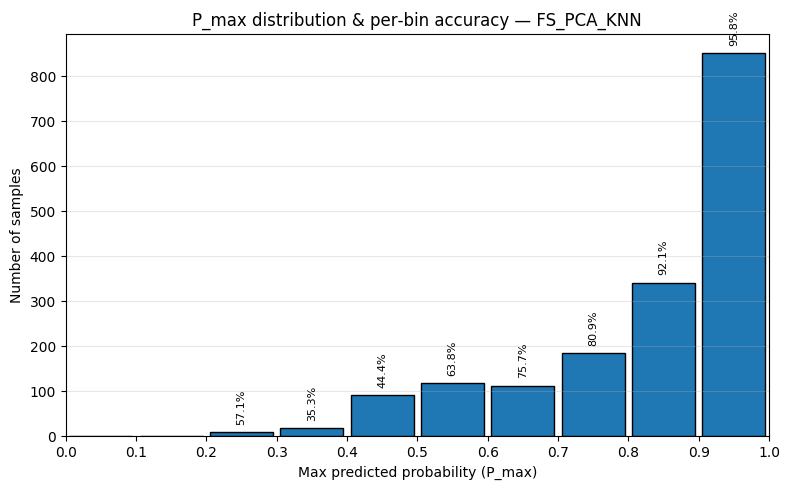

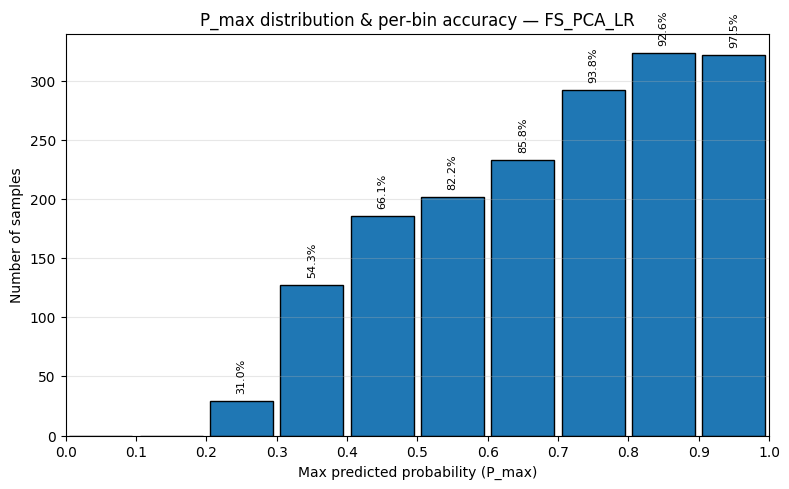

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === 1. Paths & constants =====================================================
DATA_ROOT = os.getenv('DATA_ROOT', '.')
DATA_PATH = os.path.join(DATA_ROOT, 'Cancer2025exam.csv')

OUTPUT_ROOT = os.path.join(DATA_ROOT, 'output')
INDICES_DIR = os.path.join(OUTPUT_ROOT, 'indices')
PROBABILITIES_DIR = os.path.join(OUTPUT_ROOT, 'probabilities')

N_FOLDS = 10
MODEL_SET = ['FS_PCA_NN', 'RF', 'FS_PCA_QDA', 'FS_PCA_KNN', 'FS_PCA_LR']  # exclude SVM

# === 2. Load ground‑truth labels ==============================================
df = pd.read_csv(DATA_PATH)
y_true_all = df.iloc[:, 0].values      # first column is label
print(f"Dataset loaded — {len(y_true_all)} samples, {df.shape[1] - 1} features.")

# === 3. Helper: aggregate p_max & correctness per model =======================
bin_edges = np.linspace(0, 1, 11)          # 10 bins: [0,0.1),[0.1,0.2),..., [0.9,1]
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
hist_data = {}          # model -> (counts_total, counts_correct)

for model in MODEL_SET:
    counts_total = np.zeros(10, dtype=int)
    counts_correct = np.zeros(10, dtype=int)
    
    for fold in range(1, N_FOLDS + 1):
        prob_file = os.path.join(PROBABILITIES_DIR, f"pred_dist_{model}_{fold}.npy")
        if not os.path.exists(prob_file):
            continue
        
        # columns = [sample_id, p_class0, p_class1, ...]
        arr = np.load(prob_file)
        sample_ids = arr[:, 0].astype(int)
        probs = arr[:, 1:]
        
        p_max = probs.max(axis=1)
        y_pred = probs.argmax(axis=1) + 1         # predicted class (by max‑prob)
        y_true = y_true_all[sample_ids]        # ground‑truth labels for those ids
        correct_flags = (y_pred == y_true)
        
        # accumulate per bin
        for p, correct in zip(p_max, correct_flags):
            # ensure p=1.0 ends up in last bin
            bin_idx = min(int(p * 10), 9)
            counts_total[bin_idx] += 1
            if correct:
                counts_correct[bin_idx] += 1

    
    hist_data[model] = (counts_total, counts_correct)

# === 4. Plot per‑model histograms =============================================
save_dir = os.path.join(OUTPUT_ROOT, 'pmax_histograms')
os.makedirs(save_dir, exist_ok=True)

for model, (total, corr) in hist_data.items():
    fig, ax = plt.subplots(figsize=(8, 5))
    
    ax.bar(bin_centers, total, width=0.09, align='center', edgecolor='black')
    ax.set_xlabel('Max predicted probability (P_max)')
    ax.set_ylabel('Number of samples')
    ax.set_title(f'P_max distribution & per‑bin accuracy — {model}')
    ax.set_xticks(bin_edges)
    ax.set_xlim(0, 1)
    ax.grid(axis='y', alpha=0.3)
    
    # annotate accuracy on bars
    for i, (cnt, cor) in enumerate(zip(total, corr)):
        if cnt > 0:
            acc_pct = cor / cnt * 100
            ax.text(bin_centers[i], cnt + max(total)*0.02, f'{acc_pct:.1f}%', 
                    ha='center', va='bottom', fontsize=8, rotation=90)
    
    fig.tight_layout()
    fname = os.path.join(save_dir, f'pmax_hist_{model}.png')
    plt.savefig(fname, dpi=300)
    plt.show()




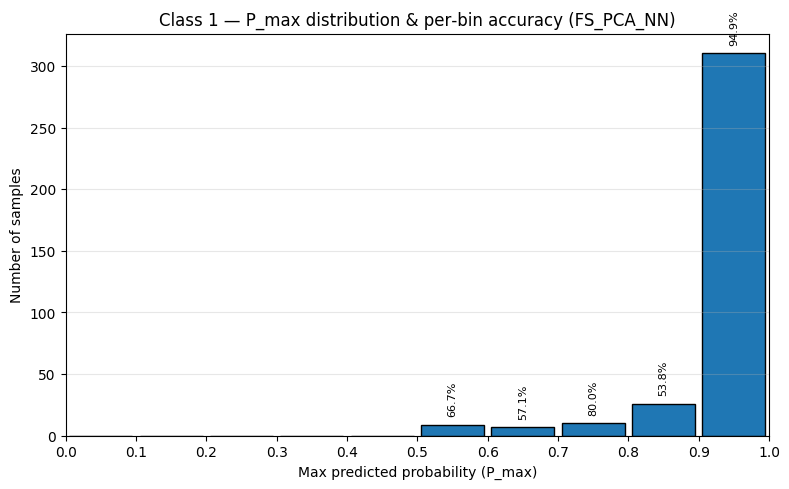

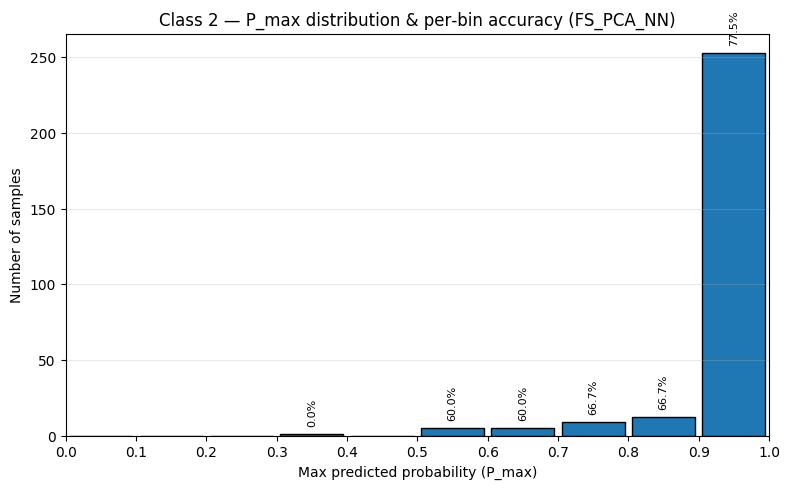

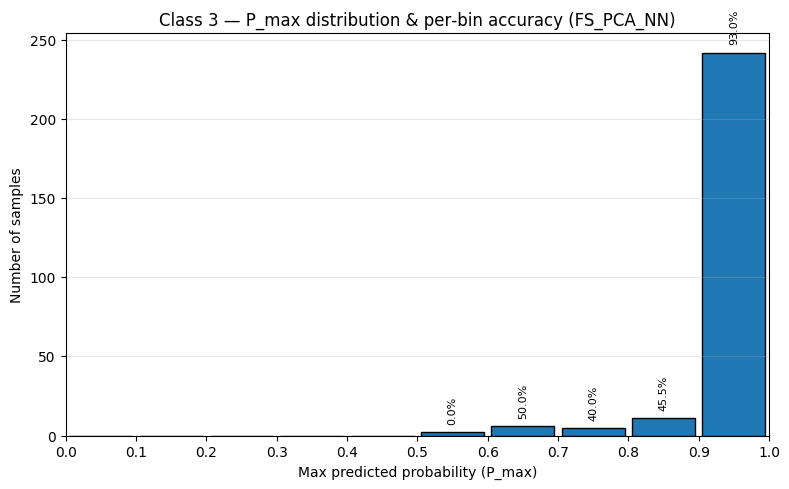

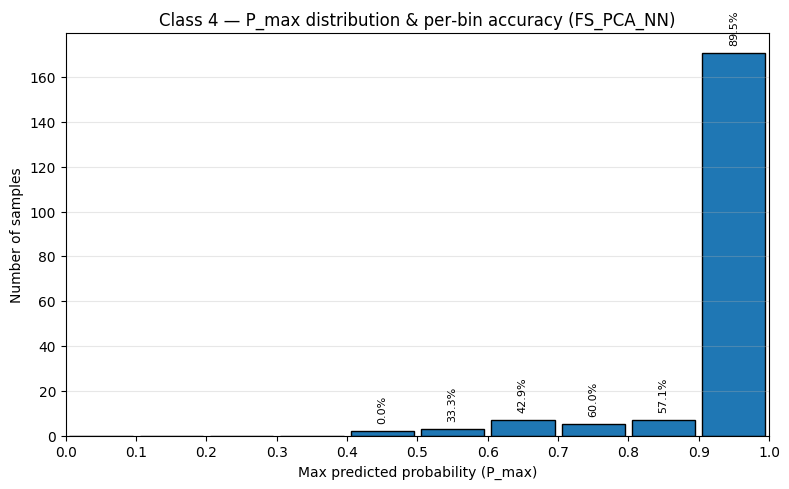

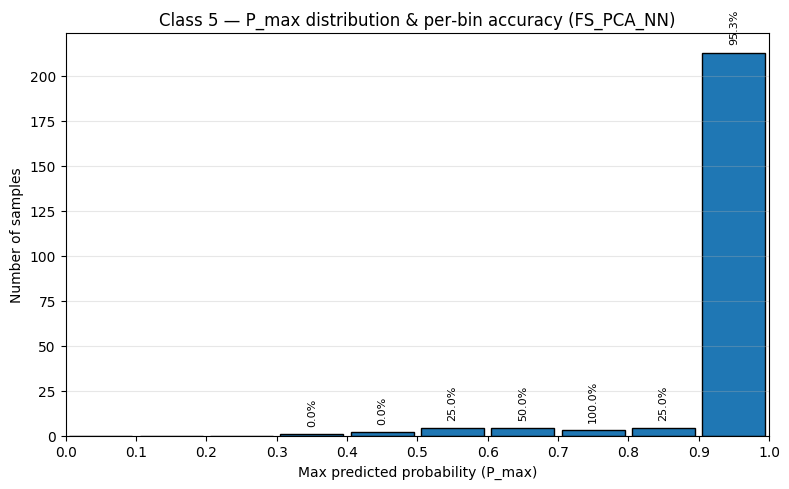

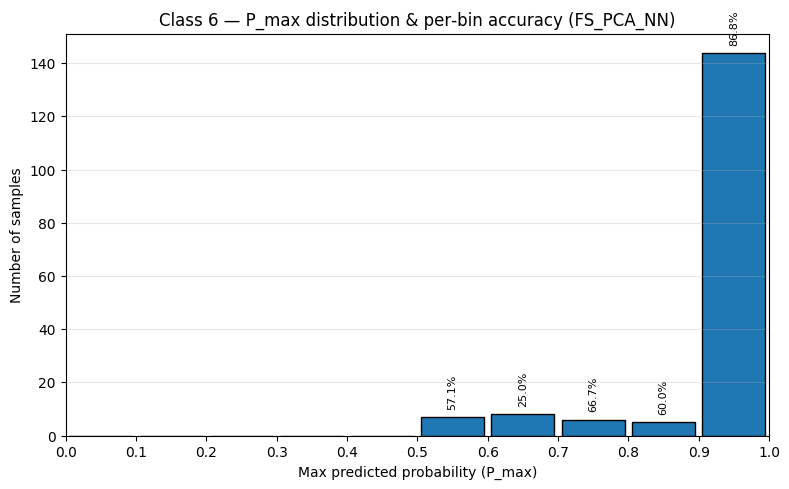

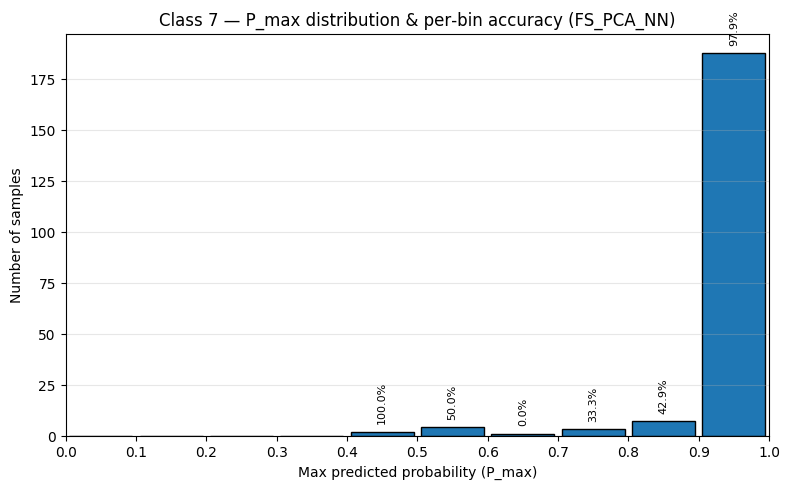

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === 1. Paths & constants =====================================================
DATA_ROOT = os.getenv('DATA_ROOT', '.')
DATA_PATH = os.path.join(DATA_ROOT, 'Cancer2025exam.csv')

OUTPUT_ROOT = os.path.join(DATA_ROOT, 'output')
INDICES_DIR = os.path.join(OUTPUT_ROOT, 'indices')
PROBABILITIES_DIR = os.path.join(OUTPUT_ROOT, 'probabilities')

MODEL_NAME = 'FS_PCA_NN'
N_FOLDS = 10
BIN_EDGES = np.linspace(0, 1, 11)  # 10 bins
BIN_CENTERS = (BIN_EDGES[:-1] + BIN_EDGES[1:]) / 2

# === 2. Load ground‑truth labels ==============================================
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Cannot find dataset at {DATA_PATH}. Adjust DATA_PATH if necessary.")

df = pd.read_csv(DATA_PATH)
y_true_all = df.iloc[:, 0].values
unique_labels = np.unique(y_true_all)

# === 3. Accumulate p_max & correctness per class ==============================
# For each class -> (total_counts, correct_counts)
class_hist_data = {cl: (np.zeros(10, dtype=int), np.zeros(10, dtype=int)) for cl in unique_labels}

for fold in range(1, N_FOLDS + 1):
    prob_file = os.path.join(PROBABILITIES_DIR, f"pred_dist_{MODEL_NAME}_{fold}.npy")
    if not os.path.exists(prob_file):
        continue
    
    arr = np.load(prob_file)
    sample_ids = arr[:, 0].astype(int)
    probs = arr[:, 1:]
    
    p_max = probs.max(axis=1)
    y_pred = probs.argmax(axis=1) + 1
    y_true = y_true_all[sample_ids]
    
    for p, t, pred in zip(p_max, y_true, y_pred):
        bin_idx = min(int(p * 10), 9)
        total, correct = class_hist_data[t]
        total[bin_idx] += 1
        if pred == t:
            correct[bin_idx] += 1

# === 4. Plot per‑class histograms =============================================
save_dir = os.path.join(OUTPUT_ROOT, 'pmax_histograms_classwise')
os.makedirs(save_dir, exist_ok=True)

for cl in unique_labels:
    total, correct = class_hist_data[cl]
    
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.bar(BIN_CENTERS, total, width=0.09, align='center', edgecolor='black')
    
    ax.set_xlabel('Max predicted probability (P_max)')
    ax.set_ylabel('Number of samples')
    ax.set_title(f'Class {cl} — P_max distribution & per‑bin accuracy ({MODEL_NAME})')
    ax.set_xticks(BIN_EDGES)
    ax.set_xlim(0, 1)
    ax.grid(axis='y', alpha=0.3)
    
    for i, (cnt, cor) in enumerate(zip(total, correct)):
        if cnt > 0:
            acc_pct = cor / cnt * 100
            ax.text(BIN_CENTERS[i], cnt + max(total)*0.02, f'{acc_pct:.1f}%', 
                    ha='center', va='bottom', fontsize=8, rotation=90)
    
    fig.tight_layout()
    fname = os.path.join(save_dir, f'class_{cl}_pmax_hist_{MODEL_NAME}.png')
    plt.savefig(fname, dpi=300)
    plt.show()


(0.0, 89.09090909090908)

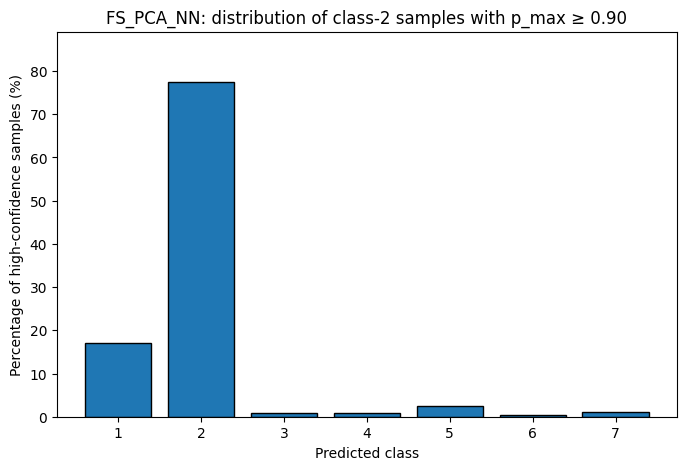

In [6]:
#!/usr/bin/env python3
"""
Class-2 高置信度样本的预测分布
—————————————————————————————————
• 读取 NN (FS_PCA_NN) 的 10 折预测结果
• 挑出 true_label == 2 且 p_max ≥ 0.9 的样本
• 统计它们被分到各类的数量 & 百分比
• 画柱状图：x=预测类, y=百分比
"""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- 路径与常量 ----------
DATA_ROOT   = os.getenv("DATA_ROOT", ".")
DATA_PATH   = os.path.join(DATA_ROOT, "Cancer2025exam.csv")
OUT_ROOT    = os.path.join(DATA_ROOT, "output")
PROB_DIR    = os.path.join(OUT_ROOT, "probabilities")

MODEL_NAME  = "FS_PCA_NN"
N_FOLDS     = 10
TRUE_CLASS  = 2            # 目标：真实标签 = 2
THRESHOLD   = 0.90         # p_max ≥ 0.9 视作“高置信度”

# ---------- 读取数据 ----------
df          = pd.read_csv(DATA_PATH)
y_true_all  = df.iloc[:, 0].values
unique_lbls = np.unique(y_true_all)

# 统计容器：pred_class -> 计数
count_dict = {cl: 0 for cl in unique_lbls}

for fold in range(1, N_FOLDS + 1):
    prob_file = os.path.join(PROB_DIR,
                             f"pred_dist_{MODEL_NAME}_{fold}.npy")
    if not os.path.exists(prob_file):
        print(f"*** 跳过：{prob_file} 不存在 ***")
        continue

    arr        = np.load(prob_file)
    sample_id  = arr[:, 0].astype(int)
    probs      = arr[:, 1:]

    p_max      = probs.max(axis=1)
    y_pred     = probs.argmax(axis=1) + 1  
    y_true     = y_true_all[sample_id]

    mask       = (y_true == TRUE_CLASS) & (p_max >= THRESHOLD)

    for pred in y_pred[mask]:
        count_dict[pred] += 1

# ---------- 转成百分比 ----------
total_selected = sum(count_dict.values())
percent_dict   = {cl: (cnt / total_selected * 100 if total_selected else 0)
                  for cl, cnt in count_dict.items()}

# ---------- 画图 ----------
classes   = list(percent_dict.keys())
perc_vals = [percent_dict[cl] for cl in classes]

fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(classes, perc_vals, edgecolor="black")

ax.set_xlabel("Predicted class")
ax.set_ylabel("Percentage of high-confidence samples (%)")
ax.set_title(f"FS_PCA_NN: distribution of class-2 samples with p_max ≥ {THRESHOLD:.2f}")
ax.set_ylim(0, max(perc_vals) * 1.15)

# 在柱
